In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import catboost
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

## Feature enginering

In [2]:
def preprocess(data, scales=None):
    # Create ticket feature
    data["CabinAfter"] = data["Cabin"].str.extract(r'([A-Za-z])')
    data["CabinAfter"].replace(to_replace=["T"], value="U", inplace=True)
    # Filling missing values with median
    data["Age"] = data["Age"].fillna(data["Age"].median())
    data["Fare"] = data["Fare"].fillna(data["Fare"].median())
    data["CabinAfter"] = data["CabinAfter"].fillna("U")
    # Filling missing embarked with C
    data["Embarked"] = data["Embarked"].fillna("C")
    # Creating family feature
    data["Family"] = data["SibSp"] + data["Parch"]
    # Alone feature
    data["Alone"] = (data["Family"] == 0).astype(int)
    # Creating title feature
    data["Title"] = data["Name"].str.extract(r'([A-Za-z]*[.])')
    data["Title"].replace(to_replace=["Dona.", "Dr.", "Rev.", "Col.", "Mlle.", "Major.", "Countess.", "Lady.", "Don.", "Mme.", "Sir.", "Jonkheer.", "Capt.", "Ms."], value="Other.", inplace=True)

    # One hot encode categorical data (class, embarked, title and sex)
    data["Sex"] = pd.get_dummies(data["Sex"])
    data = pd.concat([data, pd.get_dummies(data["Pclass"], prefix='Class')], axis=1)
    data = pd.concat([data, pd.get_dummies(data["Embarked"], prefix='Embarked')], axis=1)
    data = pd.concat([data, pd.get_dummies(data["Title"], prefix='Title')], axis=1)
#     data = pd.concat([data, pd.get_dummies(data["CabinAfter"], prefix='Cabin')], axis=1)
    
    data["Fare"] /= (data["Family"] + 1)
    
    # Dropping useless columns
    data.drop(columns=[
        'Name',
        'SibSp',
        'Parch',
        'Pclass',
        'Ticket',
        'Embarked',
        'Title',
        'CabinAfter',
        'Cabin'], inplace=True)

    # Normalizing data
    if (scales == None):
        scales = {}
    cols = list(data.columns)
    if ("Survived" in cols):
        cols.remove("Survived")
    cols.remove("PassengerId")
    for column in cols:
        if (not column in scales):
            scales[column] = {'mean': data[column].mean(), 'std': data[column].std()}
        data[column] -= scales[column]['mean']
        data[column] /= scales[column]['std']

    return scales, data

## Get training features and targets

In [3]:
train_data = pd.read_csv("train.csv")

scales, train_data = preprocess(train_data)
print(train_data.head())
# Get features and targets
train_data = train_data.dropna()
targets = train_data["Survived"].values
train_data.drop(columns=["Survived", "PassengerId"], inplace=True)
features = train_data.values
print(targets.shape, features.shape)

   PassengerId  Survived       Sex       Age      Fare    Family     Alone  \
0            1         0 -0.737281 -0.565419 -0.454543  0.059127 -1.230954   
1            2         1  1.354813  0.663488  0.438748  0.059127 -1.230954   
2            3         1  1.354813 -0.258192 -0.334569 -0.560660  0.811467   
3            4         1  1.354813  0.433068  0.185083  0.059127 -1.230954   
4            5         0 -0.737281  0.433068 -0.331081 -0.560660  0.811467   

    Class_1   Class_2   Class_3  Embarked_C  Embarked_Q  Embarked_S  \
0 -0.565368 -0.509865  0.902081   -0.485303    -0.30739    0.618959   
1  1.766775 -0.509865 -1.107304    2.058256    -0.30739   -1.613803   
2 -0.565368 -0.509865  0.902081   -0.485303    -0.30739    0.618959   
3  1.766775 -0.509865 -1.107304   -0.485303    -0.30739    0.618959   
4 -0.565368 -0.509865  0.902081   -0.485303    -0.30739    0.618959   

   Title_Master.  Title_Miss.  Title_Mr.  Title_Mrs.  Title_Other.  
0      -0.216681    -0.506371   0.8

## Get test features and targets

In [4]:
answers = pd.read_csv('./titanic.csv')
test_data = pd.read_csv('./test.csv')

for i, name in enumerate(answers['name']):
    if '"' in name:
        answers['name'][i] = re.sub('"', '', name)
        
for i, name in enumerate(test_data['Name']):
    if '"' in name:
        test_data['Name'][i] = re.sub('"', '', name)

survived = []
for name in test_data['Name']:
    survived.append(int(answers.loc[answers['name'] == name]['survived'].values[-1]))

test_data["Survived"] = survived
_, test_data = preprocess(test_data, scales=scales)
print(test_data.head())
test_targets = test_data["Survived"].values
test_data.drop(columns=["Survived", "PassengerId"], inplace=True)
test_features = test_data.values

<ipython-input-4-9aea48ee230c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answers['name'][i] = re.sub('"', '', name)
<ipython-input-4-9aea48ee230c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Name'][i] = re.sub('"', '', name)


   PassengerId       Sex       Age      Fare  Survived    Family     Alone  \
0          892 -0.737281  0.394665 -0.337242         0 -0.560660  0.811467   
1          893  1.354813  1.354749 -0.458030         1  0.059127 -1.230954   
2          894 -0.737281  2.506849 -0.285394         0 -0.560660  0.811467   
3          895 -0.737281 -0.181385 -0.313992         0 -0.560660  0.811467   
4          896  1.354813 -0.565419 -0.441406         1  0.678913 -1.230954   

    Class_1   Class_2   Class_3  Embarked_C  Embarked_Q  Embarked_S  \
0 -0.565368 -0.509865  0.902081   -0.485303    3.249548   -1.613803   
1 -0.565368 -0.509865  0.902081   -0.485303   -0.307390    0.618959   
2 -0.565368  1.959102 -1.107304   -0.485303    3.249548   -1.613803   
3 -0.565368 -0.509865  0.902081   -0.485303   -0.307390    0.618959   
4 -0.565368 -0.509865  0.902081   -0.485303   -0.307390    0.618959   

   Title_Master.  Title_Miss.  Title_Mr.  Title_Mrs.  Title_Other.  
0      -0.216681    -0.506371   0.8

## Splitting train, cross-validation and test-set

In [5]:
cv_prop = 5
i = int(features.shape[0] * cv_prop / 100)
x_train = features
y_train = targets
x_cv = features[-i:]
y_cv = targets[-i:]
x_test = test_features
y_test = test_targets

print("Train: {}".format(x_train.shape))
print("Cross-validation: {}".format(x_cv.shape))
print("Test: {}".format(x_test.shape))

Train: (891, 16)
Cross-validation: (44, 16)
Test: (418, 16)


## Keras logistic regression

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
446/446 [==============================] - 0s 1ms/step - loss: 0.6813 - binary_accuracy: 0.6083 - val_loss: 0.5818 - val_binary_accuracy: 0.6818
Epoch 2/20
446/446 [==============================] - 0s 744us/step - loss: 0.5204 - binary_accuracy: 0.7385 - val_loss: 0.4661 - val_binary_accuracy: 0.7500
Epoch 3/20
446/446 [==============================] - 0s 622us/step - loss: 0.4666 - binary_accuracy: 0.7901 - val_loss: 0.4120 - val_binary_accuracy: 0.8182
Epoch 4/20
446/446 [==============================] - 0s 586us/step - loss: 0.4440 - binary_accuracy: 0.8092 - val_loss: 0.3779 - val_binary_accuracy: 0.8182
Epoch 5/20
446/446 [====

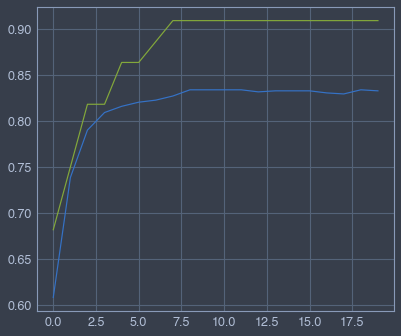

In [6]:
# Create a model
keras_log = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(features.shape[1],)),
])
keras_log.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
keras_log.summary()
history = keras_log.fit(x=features, y=targets, batch_size=2, epochs=20, shuffle=True, validation_data=(x_cv, y_cv))

y_pred = keras_log.predict(x_test) > 0.5
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.show()

## Sklearn Random Forest Classifier

Test accuracy: 73.92%


<AxesSubplot:ylabel='feature'>

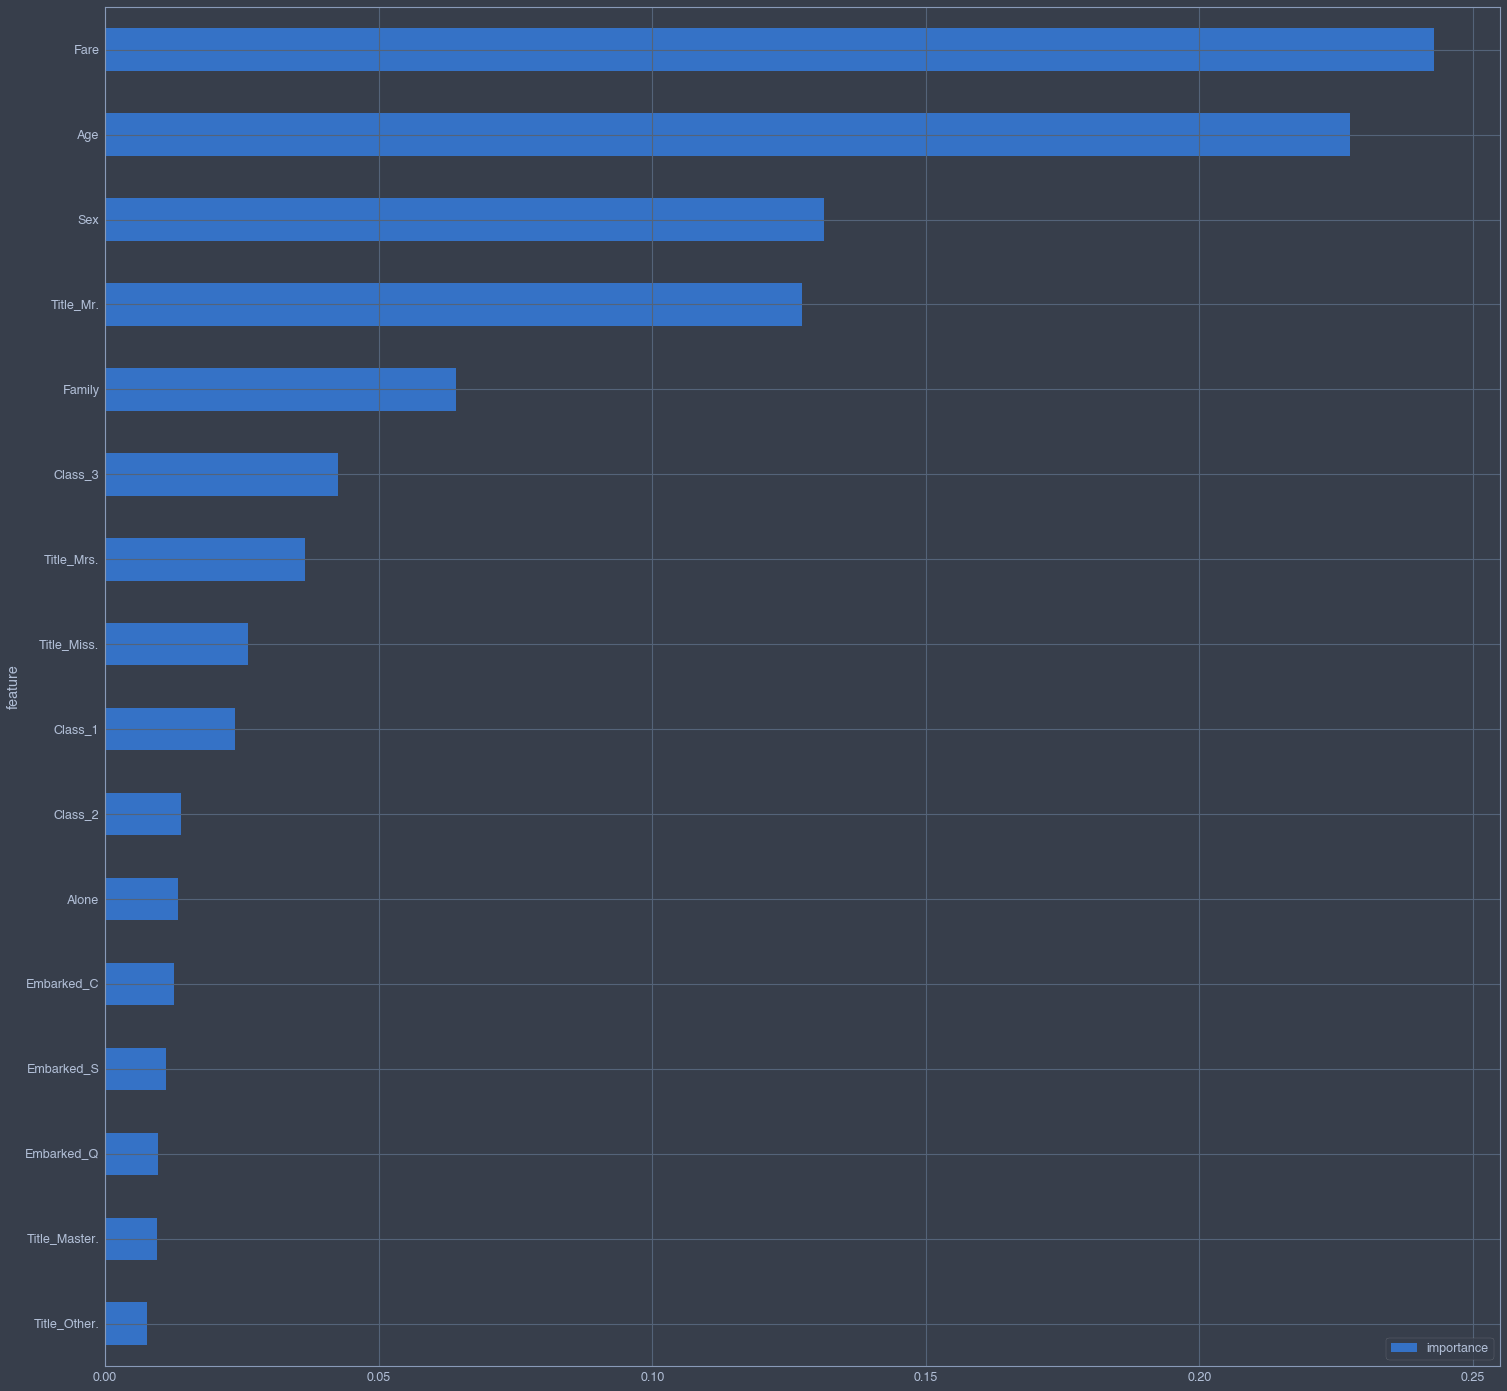

In [7]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(x_train, y_train)
y_pred=clf.predict(x_test)
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))
features = pd.DataFrame()
features['feature'] = train_data.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

## Sklearn logistic regression

In [8]:
sklearn_log = LogisticRegression()
sklearn_log.fit(x_train, y_train)
y_pred = sklearn_log.predict(x_test)
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

Test accuracy: 77.27%


## Catboost classifier

In [14]:
cboost = catboost.CatBoostClassifier(iterations=10, learning_rate=0.01)
cboost.fit(x_train, y_train, verbose=False)
y_pred = cboost.predict(x_test)
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

Test accuracy: 78.71%


## XGBClassifier


In [10]:
xgbc = XGBClassifier(learning_rate=0.01)
xgbc.fit(x_train, y_train)
y_pred = xgbc.predict(x_test)
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

Test accuracy: 75.36%


## SkLearn KNN

In [11]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

Test accuracy: 77.51%


## Catboost grid search

In [13]:
cboost2 = catboost.CatBoostClassifier()
params = {'iterations': [100],
          'depth': [4.8, 5, 5.2],
          'loss_function': ['Logloss', 'CrossEntropy'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'leaf_estimation_iterations': [6, 7, 8],
          'eval_metric': ['Accuracy'],
          'logging_level': ['Silent'],
          'random_seed': [0, 42, 84, 85]
         }
grid = GridSearchCV(estimator=cboost2, param_grid=params, cv=5)
grid.fit(x_train, y_train)
best_param = grid.best_params_
print(best_param)

cboost3 = catboost.CatBoostClassifier(
    depth=best_param["depth"],
    iterations=best_param["iterations"],
    l2_leaf_reg=best_param["l2_leaf_reg"],
    leaf_estimation_iterations=best_param["leaf_estimation_iterations"],
    random_seed=best_param["random_seed"]
)
cboost3.fit(x_train, y_train)
y_pred = cboost3.predict(x_test)
print("Test accuracy: {:.2f}%".format(metrics.accuracy_score(y_pred, y_test) * 100))

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/site-packages/catboost/core.py", line 4296, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.8/site-packages/catboost/core.py", line 1792, in _fit
    train_params = self._prepare_train_params(
  File "/usr/local/lib/python3.8/site-packages/catboost/core.py", line 1724, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5532, in _catboost._check_train_params
  File "_catboost.pyx", line

{'depth': 5, 'eval_metric': 'Accuracy', 'iterations': 100, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 7, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 84}
0:	learn: 0.6716535	total: 1.18ms	remaining: 116ms
1:	learn: 0.6526992	total: 2.35ms	remaining: 115ms
2:	learn: 0.6343281	total: 3.5ms	remaining: 113ms
3:	learn: 0.6183647	total: 5.46ms	remaining: 131ms
4:	learn: 0.6014003	total: 7.27ms	remaining: 138ms
5:	learn: 0.5883389	total: 8.46ms	remaining: 133ms
6:	learn: 0.5749843	total: 9.61ms	remaining: 128ms
7:	learn: 0.5617639	total: 10.8ms	remaining: 124ms
8:	learn: 0.5504788	total: 11.9ms	remaining: 121ms
9:	learn: 0.5403663	total: 13.1ms	remaining: 118ms
10:	learn: 0.5283962	total: 14.2ms	remaining: 115ms
11:	learn: 0.5209683	total: 15.4ms	remaining: 113ms
12:	learn: 0.5119944	total: 16.5ms	remaining: 111ms
13:	learn: 0.5042899	total: 17.7ms	remaining: 109ms
14:	learn: 0.5005442	total: 18.6ms	remaining: 105ms
15:	learn: 0.4928069	total: 20.1ms	remainin

## Predicting the test set

In [15]:
MODEL = cboost

test_data = pd.read_csv("test.csv")
_, test_data = preprocess(test_data, scales=scales)

test_without_id = test_data.drop(columns=["PassengerId"])
prediction = MODEL.predict(test_without_id.values) >= 0.5
prediction = prediction.astype(int)

test_data["Survived"] = prediction
cols = list(test_data.columns)
cols.remove("PassengerId")
cols.remove("Survived")
test_data.drop(columns=cols, inplace=True)

In [16]:
test_data.to_csv('result.csv', index=False)